# Max Independent Set

In the Maximum Independent Set Problem [[1](#MISWiki)], the challenge is to find the largest subset of vertices in a given graph, such that no two vertices in the subset are adjacent. This is an NP-hard problem in general graph structures, with applications in various fields such as network design, bioinformatics, and scheduling.

## Mathematical Formulation
Given a graph $G=(V,E)$, an independent set $I \subseteq V$ is a set of vertices such that no two vertices in $I$ are adjacent. The Maximum Independent Set Problem is the problem of finding the independent set $I$ with maximum cardinality. In binary form, each vertex $v$ is represented as being in or out of the independent set $I$ by a binary variable $x_v$, with $x_v = 1$ if $v \in I$, and $x_v = 0$ otherwise. The problem can then be formulated as

Maximize $\sum_{v \in V} x_v$

subject to

$x_{u} + x_{v} \leq 1, \forall (u, v) \in E$

where each $x_v \in {0,1}$.


## Solving with the Classiq Platform

Go through the steps of solving the problem with the Classiq platform, using the Quantum Approximate Optimization Algorithm (QAOA) [[2](#QAOA)]. The solution is based on defining a Pyomo model for the optimization problem to solve:

In [1]:
import networkx as nx
import numpy as np
import pyomo.core as pyo
from IPython.display import Markdown, display
from matplotlib import pyplot as plt

## Building the Pyomo Model from Graph Input

Define the Pyomo model to use on the Classiq platform, with the mathematical formulation defined above:

In [2]:
def mis(graph: nx.Graph) -> pyo.ConcreteModel:
    model = pyo.ConcreteModel()
    model.x = pyo.Var(graph.nodes, domain=pyo.Binary)

    @model.Constraint(graph.edges)
    def independent_rule(model, node1, node2):
        return model.x[node1] + model.x[node2] <= 1

    model.cost = pyo.Objective(expr=sum(model.x.values()), sense=pyo.maximize)

    return model

The model consists of

- Index set declarations (`model.Nodes`, `model.Arcs`).
- Binary variable declaration for each node (`model.x`) indicating whether that node is included in the set.
- Constraint rule - for each edge, at least one of the corresponding node variables is 0.
- Objective rule – the sum of the variables equals the set size.

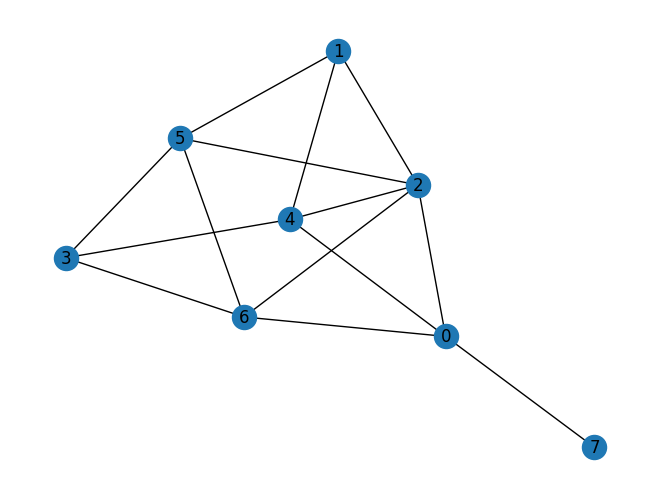

In [3]:
num_nodes = 8
p_edge = 0.4
graph = nx.fast_gnp_random_graph(n=num_nodes, p=p_edge, seed=12345)

nx.draw_kamada_kawai(graph, with_labels=True)
mis_model = mis(graph)

In [4]:
mis_model.pprint()

1 Var Declarations
    x : Size=8, Index={0, 1, 2, 3, 4, 5, 6, 7}
        Key : Lower : Value : Upper : Fixed : Stale : Domain
          0 :     0 :  None :     1 : False :  True : Binary
          1 :     0 :  None :     1 : False :  True : Binary
          2 :     0 :  None :     1 : False :  True : Binary
          3 :     0 :  None :     1 : False :  True : Binary
          4 :     0 :  None :     1 : False :  True : Binary
          5 :     0 :  None :     1 : False :  True : Binary
          6 :     0 :  None :     1 : False :  True : Binary
          7 :     0 :  None :     1 : False :  True : Binary

1 Objective Declarations
    cost : Size=1, Index=None, Active=True
        Key  : Active : Sense    : Expression
        None :   True : maximize : x[0] + x[1] + x[2] + x[3] + x[4] + x[5] + x[6] + x[7]

1 Constraint Declarations
    independent_rule : Size=14, Index={(0, 7), (2, 4), (1, 2), (0, 4), (3, 4), (1, 5), (1, 4), (0, 6), (0, 2), (2, 6), (5, 6), (3, 6), (2, 5), (3, 5)}, Ac

## Setting Up the Classiq Problem Instance

To solve the Pyomo model defined above, use the `CombinatorialProblem` Python class. Under the hood, it translates the Pyomo model to a quantum model of QAOA, with a cost Hamiltonian translated from the Pyomo model. Choose the number of layers for the QAOA ansatz using the `num_layers` argument:

In [5]:
from classiq import *
from classiq.applications.combinatorial_optimization import CombinatorialProblem

combi = CombinatorialProblem(pyo_model=mis_model, num_layers=3)

qmod = combi.get_model()

## Synthesizing the QAOA Circuit and Solving the Problem

Synthesize and view the QAOA circuit (ansatz) used to solve the optimization problem:

In [6]:
qprog = combi.get_qprog()
show(qprog)

Quantum program link: https://platform.classiq.io/circuit/39FhfvIzGJnBrxpW2A41Nyl81zx


https://platform.classiq.io/circuit/39FhfvIzGJnBrxpW2A41Nyl81zx?login=True&version=17

Solve the problem by calling the `optimize` method of the `CombinatorialProblem` object. For the classical optimization part of the QAOA algorithm, define the maximum number of classical iterations (`maxiter`) and the $\alpha$-parameter (`quantile`) for running CVaR-QAOA, an improved variation of QAOA [[3](#cvar)]:

In [7]:
optimized_params = combi.optimize(maxiter=60, quantile=0.7)

Check the convergence of the run:

Text(0.5, 1.0, 'Cost convergence')

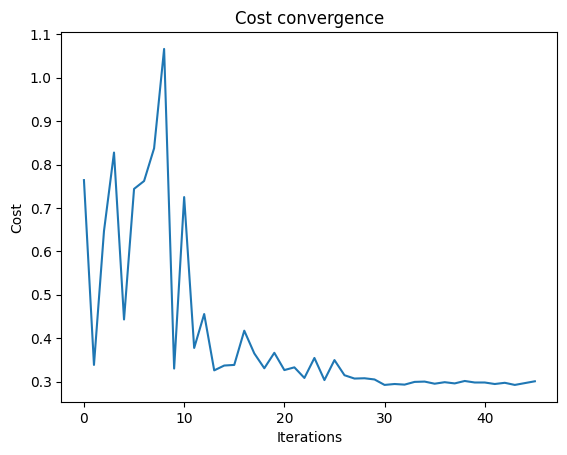

In [8]:
plt.plot(combi.cost_trace)
plt.xlabel("Iterations")
plt.ylabel("Cost")
plt.title("Cost convergence")

## Optimization Results

Examine the statistics of the algorithm. The optimization is always defined as a minimization problem, so the Pyomo-to-Qmod translator changes the positive maximization objective to negative minimization.

To get samples with the optimized parameters, call the `sample` method:

In [9]:
optimization_result = combi.sample(optimized_params)
optimization_result.sort_values(by="cost").head(5)

,solution,probability,cost
0,"{'x': [0, 1, 0, 1, 0, 0, 0, 1]}",0.025391,-3
8,"{'x': [0, 0, 0, 0, 1, 1, 0, 1]}",0.017578,-3
35,"{'x': [1, 1, 0, 1, 0, 0, 0, 0]}",0.007812,-3
79,"{'x': [0, 1, 0, 0, 0, 0, 1, 1]}",0.004395,-3
108,"{'x': [0, 0, 1, 1, 0, 0, 0, 1]}",0.002930,-3


Compare the optimized results to uniformly sampled results:

In [10]:
uniform_result = combi.sample_uniform()

And compare the histograms:

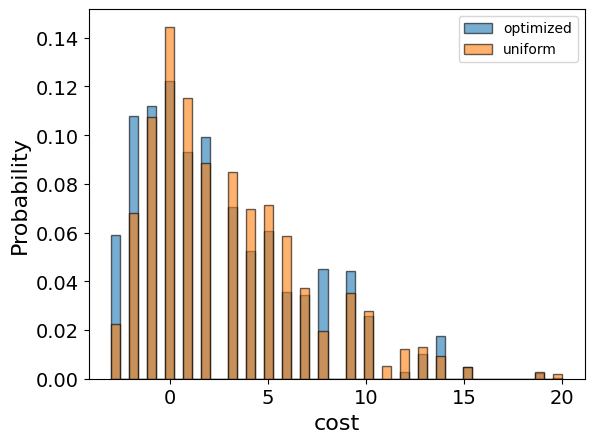

In [11]:
optimization_result["cost"].plot(
    kind="hist",
    bins=50,
    edgecolor="black",
    weights=optimization_result["probability"],
    alpha=0.6,
    label="optimized",
)
uniform_result["cost"].plot(
    kind="hist",
    bins=50,
    edgecolor="black",
    weights=uniform_result["probability"],
    alpha=0.6,
    label="uniform",
)
plt.legend()
plt.ylabel("Probability", fontsize=16)
plt.xlabel("cost", fontsize=16)
plt.tick_params(axis="both", labelsize=14)

Plot the best solution:

In [12]:
best_solution = optimization_result.solution[optimization_result.cost.idxmin()]["x"]

In [13]:
independent_set = [node for node in graph.nodes if best_solution[node] == 1]
print("Independent Set: ", independent_set)
print("Size of Independent Set: ", len(independent_set))

Independent Set:  [1, 3, 7]
Size of Independent Set:  3


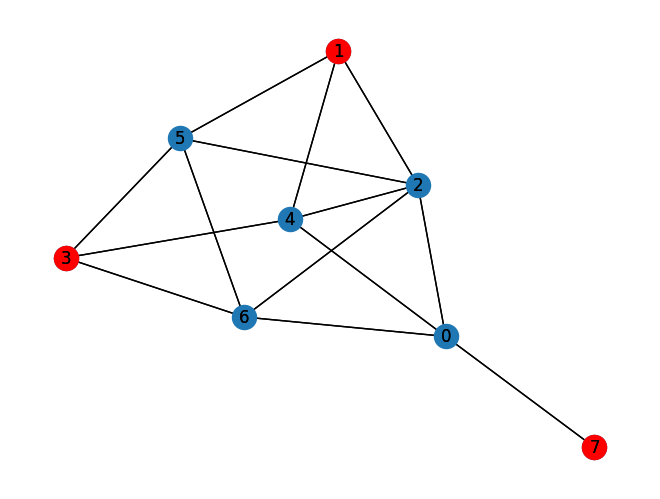

In [14]:
nx.draw_kamada_kawai(graph, with_labels=True)
nx.draw_kamada_kawai(
    graph,
    with_labels=True,
    nodelist=independent_set,
    node_color="r",
)

Lastly, compare to the classical solution of the problem:

In [15]:
from pyomo.opt import SolverFactory

solver = SolverFactory("couenne")
solver.solve(mis_model)
classical_solution = [pyo.value(mis_model.x[i]) for i in graph.nodes]

In [16]:
independent_set_classical = [
    node for node in graph.nodes if np.allclose(classical_solution[node], 1)
]
print("Classical Independent Set: ", independent_set_classical)
print("Size of Classical Independent Set: ", len(independent_set_classical))

Classical Independent Set:  [0, 1, 3]
Size of Classical Independent Set:  3


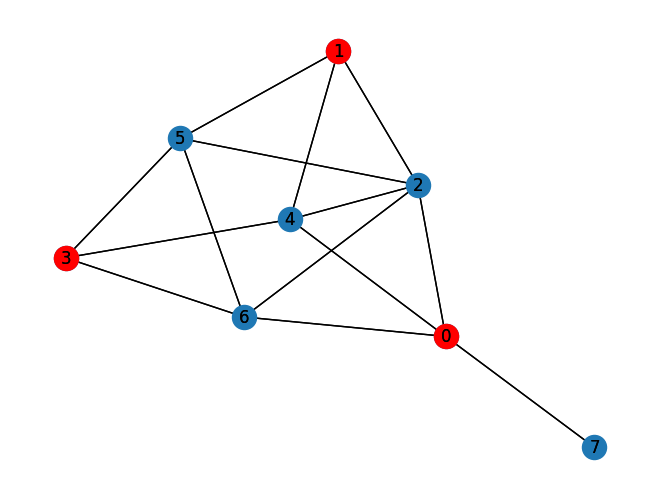

In [17]:
nx.draw_kamada_kawai(graph, with_labels=True)
nx.draw_kamada_kawai(
    graph,
    with_labels=True,
    nodelist=independent_set_classical,
    node_color="r",
)


## References

<a id='MISWiki'>[1]</a> [Max Independent Set (Wikipedia).](https://en.wikipedia.org/wiki/Partition_problem)

<a id='QAOA'>[2]</a> [Farhi, Edward, Jeffrey Goldstone, and Sam Gutmann. (2014). A quantum approximate optimization algorithm. arXiv preprint arXiv:1411.4028.](https://arxiv.org/abs/1411.4028)

<a id='cvar'>[3]</a> [Barkoutsos, Panagiotis Kl, et al. (2020). Improving variational quantum optimization using CVaR. Quantum 4 (2020): 256.](https://arxiv.org/abs/1907.04769)
